# Bibliotecas

In [ ]:
from obterDados import obterSimboloPosicao, obterSimboloData
from MetaTrader5 import TIMEFRAME_D1
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

# Gerando dados

In [ ]:
rawDataD1 = obterSimboloPosicao('ITSA4', TIMEFRAME_D1)
rawDataD1

In [ ]:
reservaTeste = 50

rawDataD1NP = rawDataD1.filter(['close']).to_numpy()[:-reservaTeste]
rawDataD1NP

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
rawDataD1NPScaled = sc.fit_transform(rawDataD1NP)

In [ ]:
nPassado = 250
nFuturo = 22

x = np.zeros((len(rawDataD1NPScaled) - nPassado - nFuturo, nPassado, 1))
y = np.zeros((len(rawDataD1NPScaled) - nPassado - nFuturo, nFuturo))
for i in tqdm(range(len(x))):
    x[i] = rawDataD1NPScaled[i:i+nPassado]
    y[i] = rawDataD1NPScaled[i+nPassado:i+nPassado+nFuturo, 0]
x.shape

# Criar Modelo

In [ ]:
modelo = Sequential()

modelo.add(LSTM(units=50,return_sequences=True,input_shape=(x.shape[1], 1)))
modelo.add(Dropout(0.2))
modelo.add(LSTM(units=50,return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(LSTM(units=50,return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(LSTM(units=50))
modelo.add(Dropout(0.2))
modelo.add(Dense(y.shape[1]))

modelo.compile(optimizer='adam', loss='mean_squared_error')

modelo.summary()

# Treinar Modelo

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/lstm/")
# checkpoint_filepath = '/tmp/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True
# )
parada_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)
modelo.fit(
    x,
    y,
    epochs=500,
    batch_size=32,
    validation_split=0.1,
    callbacks=[tensorboard_callback, parada_callback]
)

In [ ]:
modelo.save('models/tf-lstm-model')

# Testar modelo

In [89]:
from keras.models import load_model

modelo = load_model('models/tf-lstm-model')
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 250, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 250, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 250, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 250, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 250, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [90]:
rawTestData = obterSimboloPosicao('ITSA4', TIMEFRAME_D1, n=reservaTeste+nPassado+nFuturo)
testData = rawTestData.filter(['close']).to_numpy()
testDataScaled = sc.transform(testData)

x_test = np.zeros((reservaTeste, nPassado, 1))
y_test = np.zeros((reservaTeste, nFuturo))
for i in range(reservaTeste):
    x_test[i] = testDataScaled[i:i+nPassado]
    y_test[i] = testDataScaled[i+nPassado:i+nPassado+nFuturo, 0]

### Previsão com dados existentes

2/2 [==============================] - 0s 137ms/step


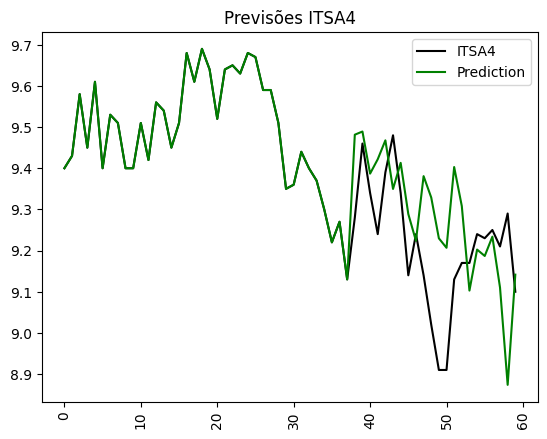

In [174]:
from matplotlib import pyplot as plt

predictions = sc.inverse_transform(modelo.predict(x_test))
showIdx = 49
historyCloses = 60
plt.plot(testData[showIdx:showIdx+272][-historyCloses:], color = 'black', label = 'ITSA4')
predZeros = np.zeros(nPassado+nFuturo)
predZeros[:-nFuturo] = sc.inverse_transform(x_test[showIdx])[:, 0]
predZeros[-nFuturo:] = predictions[showIdx]
plt.plot(predZeros[-historyCloses:], color = 'green', label = 'Prediction')
plt.title('Previsões ITSA4')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Previsão de uma semana

1/1 [==============================] - 0s 85ms/step


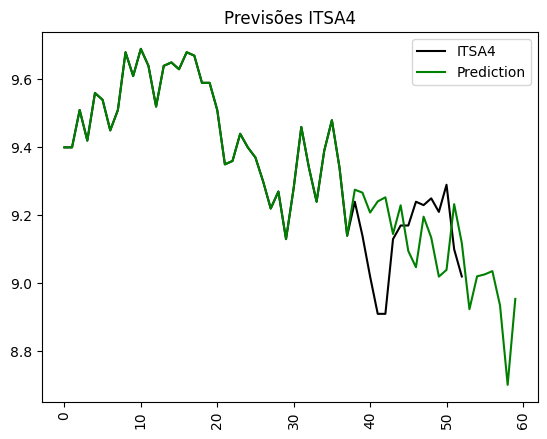

In [175]:
from matplotlib import pyplot as plt

dias = 15
predictions = sc.inverse_transform(modelo.predict(np.array([testDataScaled[-(nPassado+dias):-(dias)]])))
plt.plot(testData[-(historyCloses-7):], color = 'black', label = 'ITSA4')
predZeros = np.zeros(nPassado+nFuturo)
predZeros[:-nFuturo] = testData[-(nPassado+dias):-(dias)][:, 0]
predZeros[-nFuturo:] = predictions[0]
plt.plot(predZeros[-historyCloses:], color = 'green', label = 'Prediction')
plt.title('Previsões ITSA4')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Previsão de duas semanas

1/1 [==============================] - 0s 63ms/step


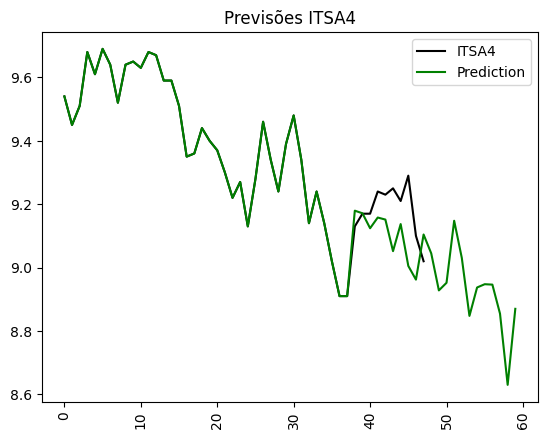

In [176]:
from matplotlib import pyplot as plt

dias = 10
predictions = sc.inverse_transform(modelo.predict(np.array([testDataScaled[-(nPassado+dias):-(dias)]])))
plt.plot(testData[-(historyCloses-12):], color = 'black', label = 'ITSA4')
predZeros = np.zeros(nPassado+nFuturo)
predZeros[:-nFuturo] = testData[-(nPassado+dias):-(dias)][:, 0]
predZeros[-nFuturo:] = predictions[0]
plt.plot(predZeros[-historyCloses:], color = 'green', label = 'Prediction')
plt.title('Previsões ITSA4')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Previsão de três semanas

1/1 [==============================] - 0s 75ms/step


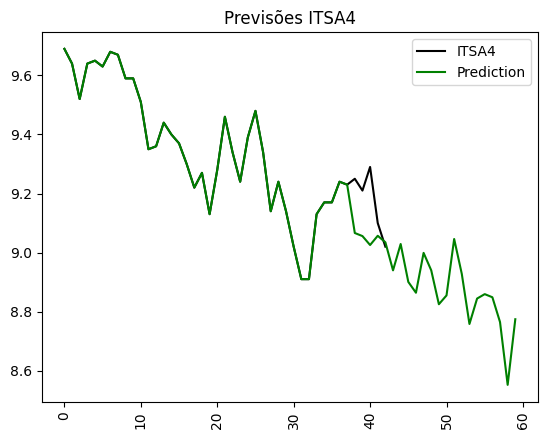

In [177]:
from matplotlib import pyplot as plt

dias = 5
predictions = sc.inverse_transform(modelo.predict(np.array([testDataScaled[-(nPassado+dias):-(dias)]])))
plt.plot(testData[-(historyCloses-17):], color = 'black', label = 'ITSA4')
predZeros = np.zeros(nPassado+nFuturo)
predZeros[:-nFuturo] = testData[-(nPassado+dias):-(dias)][:, 0]
predZeros[-nFuturo:] = predictions[0]
plt.plot(predZeros[-historyCloses:], color = 'green', label = 'Prediction')
plt.title('Previsões ITSA4')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Previsão de quatro semanas

1/1 [==============================] - 0s 94ms/step


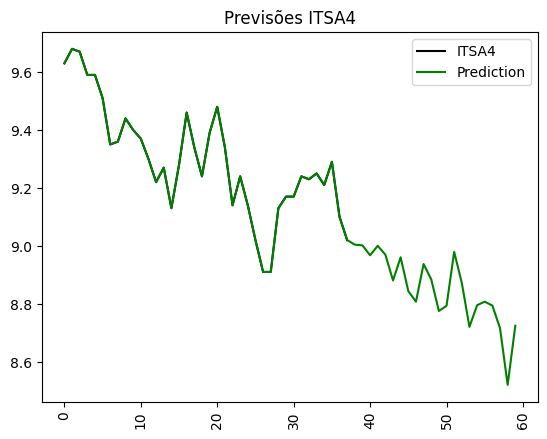

In [178]:
from matplotlib import pyplot as plt

predictions = sc.inverse_transform(modelo.predict(np.array([testDataScaled[-nPassado:]])))
plt.plot(testData[-(historyCloses-22):], color = 'black', label = 'ITSA4')
predZeros = np.zeros(nPassado+nFuturo)
predZeros[:-nFuturo] = testData[-nPassado:][:, 0]
predZeros[-nFuturo:] = predictions[0]
plt.plot(predZeros[-historyCloses:], color = 'green', label = 'Prediction')
plt.title('Previsões ITSA4')
plt.xticks(rotation=90)
plt.legend()
plt.show()